# Однослойный перцептрон
Демонстрация с цветочком

In [1]:
import numpy as np

# Функция активации нейрона в выходном слое и ее производная
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def dsigmoid(y):
    return y * (1 - y)

# Функция активации нейронов во внутреннем слое и ее производная
def tanh(x):
    return np.tanh(x)
def dtanh(y):
    return 1 - y * y

In [ ]:
from matplotlib import pyplot as plt

class Perceptron:
    def __init__(self, X, Y, hidden_size):
        
        # Пусть n - количество признаков, m - количество объектов, k - размерность результирующего вектора
        # Тогда X = X(n * m), Y = Y(k, m)
        assert X.shape[1] == Y.shape[1]
        self.X = X
        self.Y = Y
        self.m = X.shape[1]
        
        # Инициализируем матрицы весов рандомными числами (W1 - для скрытого слоя, W2 - для выходного, в нем всего 1 нейрон)
        self.W1 = np.random.randn(hidden_size, X.shape[0])
        self.W2 = np.random.randn(Y.shape[0], hidden_size)
        
        # Заполняем свободные векторы нулями
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((Y.shape[0], 1))
        
        # Здесь будем накапливать значения функции потерь на каждой итерации
        self.ce_loss = []
        self.mse_loss = []
        
    def learn(self, epochs, learning_rate, lmdb):

        for step in range(epochs):

            #Прямой проход 
            Z1 = self.W1 @ self.X + self.b1
            H = tanh(Z1)
            Z2 = self.W2 @ H + self.b2
            P = sigmoid(Z2)

            #Функция потерь MSE + L2
            reg_term = (np.sum(self.W1 * self.W1) + np.sum(self.W2 * self.W2)) * lmdb / (2 * self.m)
            mse = np.sum((P - self.Y) ** 2) / self.m + reg_term
            self.mse_loss.append(mse)

            # CE оставлена для наблюдения динамики, но не участвует в обучении
            eps = 1e-12
            P_safe = np.clip(P, eps, 1 - eps)
            ce = -np.mean(self.Y * np.log(P_safe) + (1 - self.Y) * np.log(1 - P_safe))
            self.ce_loss.append(ce)

            if step % 1000 == 0:
                print(f"Шаг {step}: MSE = {mse}, CE = {ce}")

            #Обратный ход
            dZ2 = (P - self.Y) * (P * (1 - P))
            dW2 = dZ2 @ H.T / self.m
            dW2 += (lmdb / self.m) * self.W2          
            db2 = np.mean(dZ2, axis=1, keepdims=True)

            dZ1 = (self.W2.T @ dZ2) * (1 - H * H)
            dW1 = dZ1 @ self.X.T / self.m
            dW1 += (lmdb / self.m) * self.W1            
            db1 = np.mean(dZ1, axis=1, keepdims=True)

            #Обновление параметров
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1
            
    def predict(self, X):
        # Используем найденные матрицы весов
        A1 = tanh(np.dot(self.W1, X) + self.b1)
        A2 = sigmoid(np.dot(self.W2, A1) + self.b2)
        return (A2[0] > 0.5).astype(int)
    
    def plot(self):
        plt.figure(figsize=(10,3))
        plt.subplot(1, 2, 1)
        plt.ylabel('MSE loss')
        plt.xlabel('Iterations')
        plt.plot(self.mse_loss)
        plt.subplot(1, 2, 2)
        plt.ylabel('CE loss')
        plt.xlabel('Iterations')
        plt.plot(self.ce_loss)

## Разделение цветочка

In [3]:
# Создать датасет в виде цветочка, m - кол-во объектов (целое больше 1), a - максимальная длина листа (float больше 0)
def create_flower(m, a):
    D = 2
    N = int(m/2)
    X = np.zeros((m,D))
    Y = np.zeros((m,1), dtype='uint8')
    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2
        r = a*np.sin(4*t) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
    return X.T, Y.T

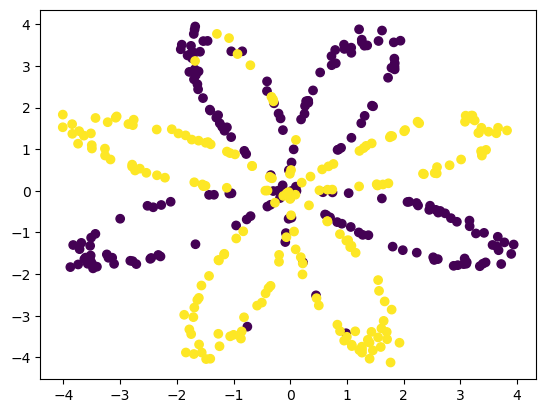

In [4]:
# Создаем и рисуем датасет в форме цветочка с 1000 объектов, цветами обозначены метки классов
X, Y = create_flower(400, 4)
plt.scatter(X[0, :], X[1, :], c=Y);

In [5]:
# Строим разделяющую  прямую, показывающую результат обучения нейросети
def plot_division(perceptron):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral);

### Один нейрон

Шаг 0: MSE = 0.2404045670616643, CE = 0.6739224337294049
Шаг 1000: MSE = 0.23155689682092898, CE = 0.6559957224276528
Шаг 2000: MSE = 0.22713957844730195, CE = 0.6469076590167141
Шаг 3000: MSE = 0.22497722997534247, CE = 0.6424211362779855
Шаг 4000: MSE = 0.22393198974232448, CE = 0.6402537771914949
Шаг 5000: MSE = 0.2234062714946833, CE = 0.6391751249798587
Шаг 6000: MSE = 0.2231169196614024, CE = 0.6385918591989531
Шаг 7000: MSE = 0.22293679933538318, CE = 0.6382348919303346
Шаг 8000: MSE = 0.2228092961889083, CE = 0.6379842050101527
Шаг 9000: MSE = 0.2227087204625876, CE = 0.6377858439835018


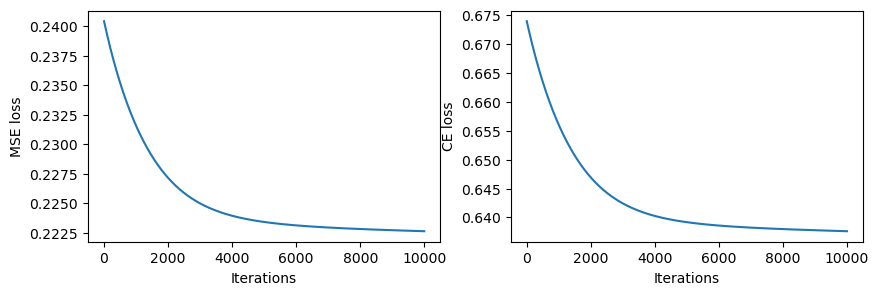

In [7]:
perceptron = Perceptron(X, Y, 1)
perceptron.learn(epochs=10000, learning_rate=0.01, lmdb=0)

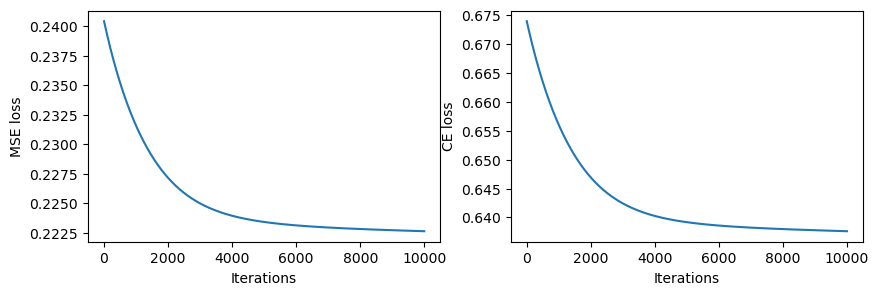

In [8]:
perceptron.plot()

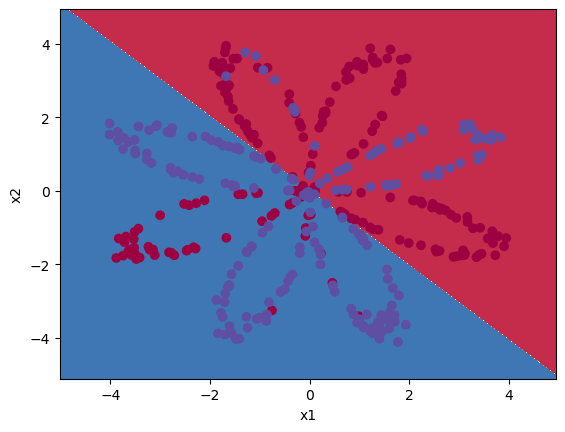

In [9]:
# Строим разделяющую  прямую, показывающую результат обучения нейросети
plot_division(perceptron)

### Четыре нейрона

In [13]:
perceptron = Perceptron(X, Y, 4)
perceptron.learn(epochs=10000, learning_rate=0.01, lmdb=0)

Шаг 0: MSE = 0.4158073831857424, CE = 1.0997540342943526
Шаг 1000: MSE = 0.2782661554643227, CE = 0.7559862877436977
Шаг 2000: MSE = 0.23663004001593946, CE = 0.6656763669628356
Шаг 3000: MSE = 0.22345300629275497, CE = 0.6385887069929926
Шаг 4000: MSE = 0.21525630303628282, CE = 0.6209811990693518
Шаг 5000: MSE = 0.20847844151520611, CE = 0.6059567511392868
Шаг 6000: MSE = 0.20263405042721533, CE = 0.5926627436742449
Шаг 7000: MSE = 0.19758666321010196, CE = 0.5808821924774606
Шаг 8000: MSE = 0.19323336993218146, CE = 0.5704543732520944
Шаг 9000: MSE = 0.18947734549953638, CE = 0.5612225747967566


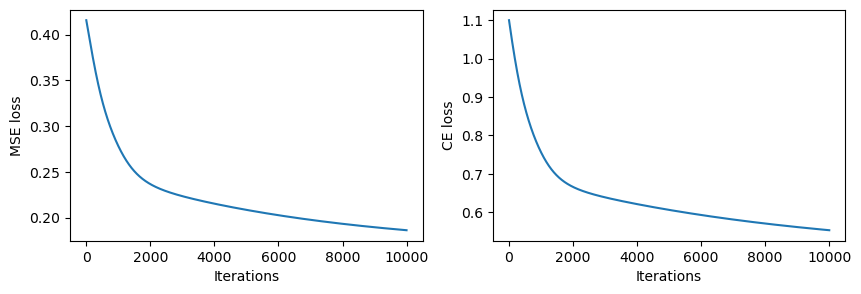

In [14]:
perceptron.plot()

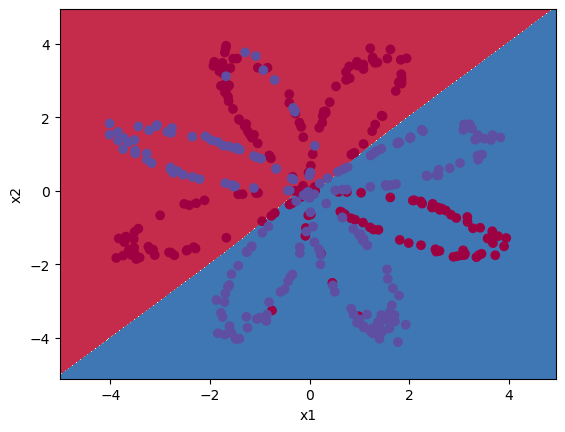

In [15]:
plot_division(perceptron)

### много нейронов - стало ли лучше?

In [17]:
perceptron = Perceptron(X, Y, 40)
perceptron.learn(epochs=10000, learning_rate=0.01, lmdb=0)

Шаг 0: MSE = 0.4871346679681547, CE = 3.111214610875858
Шаг 1000: MSE = 0.4554360877503248, CE = 2.5929064643269424
Шаг 2000: MSE = 0.3226300454274063, CE = 1.9573817385202414
Шаг 3000: MSE = 0.320193418166161, CE = 1.8508534575572595
Шаг 4000: MSE = 0.31778249201470843, CE = 1.709687263471621
Шаг 5000: MSE = 0.3102889944562357, CE = 1.4135209628134948
Шаг 6000: MSE = 0.16506172643250472, CE = 0.5052933937956336
Шаг 7000: MSE = 0.111631864256108, CE = 0.37278726713346794
Шаг 8000: MSE = 0.10083121300988596, CE = 0.3417893725493898
Шаг 9000: MSE = 0.09537055685049949, CE = 0.3246583292518028


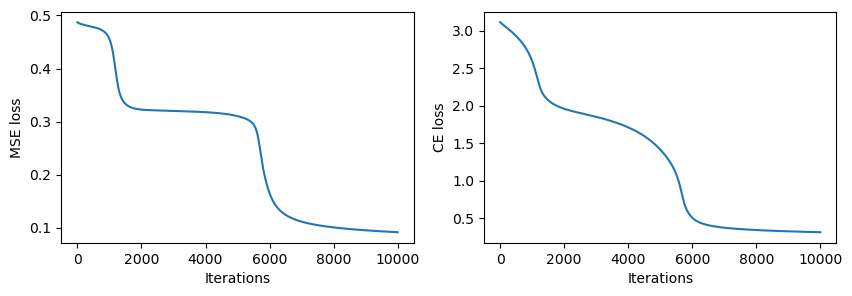

In [18]:
perceptron.plot()

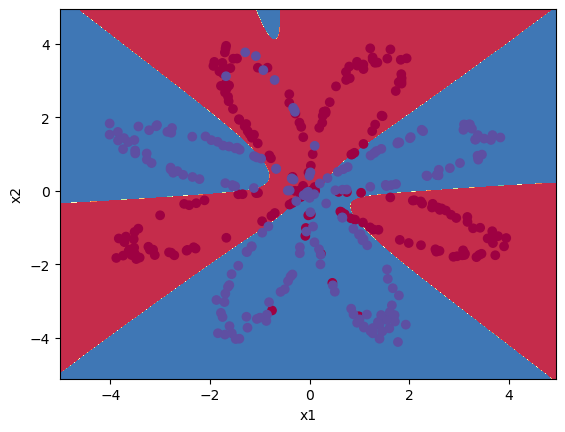

In [19]:
plot_division(perceptron)